In [1]:
%matplotlib inline

import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats

from collections import defaultdict
from datetime import datetime
from scipy.stats.stats import pearsonr

# Data Understanding

In [2]:
# Loading dataset.

custom_date_parser = lambda x: datetime.strptime(x, "%d/%m/%y %H:%M")

df = pd.read_csv('customer_supermarket.csv', sep='\t', decimal=',',
                 parse_dates=['BasketDate'], date_parser=custom_date_parser, index_col=0)

df['CustomerID'] = df['CustomerID'].astype(float)

In [3]:
df.dtypes

BasketID                   object
BasketDate         datetime64[ns]
Sale                      float64
CustomerID                float64
CustomerCountry            object
ProdID                     object
ProdDescr                  object
Qta                         int64
dtype: object

# Data Quality 

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 471910 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   BasketID         471910 non-null  object        
 1   BasketDate       471910 non-null  datetime64[ns]
 2   Sale             471910 non-null  float64       
 3   CustomerID       406830 non-null  float64       
 4   CustomerCountry  471910 non-null  object        
 5   ProdID           471910 non-null  object        
 6   ProdDescr        471157 non-null  object        
 7   Qta              471910 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.4+ MB


In [5]:
# 13% of the records have CustomerID = null.

df.isnull().sum()

BasketID               0
BasketDate             0
Sale                   0
CustomerID         65080
CustomerCountry        0
ProdID                 0
ProdDescr            753
Qta                    0
dtype: int64

In [6]:
df.describe()

,Sale,CustomerID,Qta
count,471910.000000,406830.000000,471910.000000
mean,4.030945,15287.684160,10.716533
std,83.769380,1713.603074,231.355136
min,-11062.060000,12346.000000,-80995.000000
25%,1.250000,13953.000000,1.000000
50%,2.080000,15152.000000,4.000000
75%,3.750000,16791.000000,12.000000
max,38970.000000,18287.000000,80995.000000


In [7]:
# Only these two (aborted transactions).

df[df['Sale'] < 0]

,BasketID,BasketDate,Sale,CustomerID,CustomerCountry,ProdID,ProdDescr,Qta
299983,A563186,2011-08-12 14:51:00,-11062.06,NaN,United Kingdom,B,Adjust bad debt,1
299984,A563187,2011-08-12 14:52:00,-11062.06,NaN,United Kingdom,B,Adjust bad debt,1


In [8]:
# All these BaskedIDs have a leading 'C', that means "canceled order".

df[df['Qta'] < 0]

,BasketID,BasketDate,Sale,CustomerID,CustomerCountry,ProdID,ProdDescr,Qta
141,C536379,2010-12-01 09:41:00,27.50,14527.0,United Kingdom,D,Discount,-1
154,C536383,2010-12-01 09:49:00,4.65,15311.0,United Kingdom,35004C,SET OF 3 COLOURED FLYING DUCKS,-1
235,C536391,2010-12-01 10:24:00,1.65,17548.0,United Kingdom,22556,PLASTERS IN TIN CIRCUS PARADE,-12
236,C536391,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,21984,PACK OF 12 PINK PAISLEY TISSUES,-24
237,C536391,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24
...,...,...,...,...,...,...,...,...
540449,C581490,2011-12-09 09:57:00,0.83,14397.0,United Kingdom,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11
541541,C581499,2011-12-09 10:28:00,224.69,15498.0,United Kingdom,M,Manual,-1
541715,C581568,2011-12-09 11:57:00,10.95,15311.0,United Kingdom,21258,VICTORIAN SEWING BOX LARGE,-5
541716,C581569,2011-12-09 11:58:00,1.25,17315.0,United Kingdom,84978,HANGING HEART JAR T-LIGHT HOLDER,-1


In [9]:
# Customers' nationalities.

#df['CustomerCountry'].value_counts()

# Data Cleaning

In [10]:
# Remove the (2) rows with sale < 0.

df = df[~(df['Sale'] < 0)]

In [11]:
# Create a new field "Canceled".

canceled = "C"

df['Canceled'] = df['BasketID'].apply(lambda x : x.startswith(canceled))

df['BasketID'] = df['BasketID'].apply(lambda x : x[1:] if x.startswith(canceled) else x)

df['Qta'] = np.where(df['Canceled'], abs(df['Qta']), df['Qta'])

In [12]:
# Fix BasketID type (object -> int64)

df['BasketID'] = df['BasketID'].astype(int)
df.dtypes

BasketID                    int64
BasketDate         datetime64[ns]
Sale                      float64
CustomerID                float64
CustomerCountry            object
ProdID                     object
ProdDescr                  object
Qta                         int64
Canceled                     bool
dtype: object

In [13]:
# ProdDescr null ==> (CustomerID null AND Sale = 0).

df[(df['ProdDescr'].isnull()) & ~((df['CustomerID'].isnull()) & (df['Sale'] == 0))]

,BasketID,BasketDate,Sale,CustomerID,CustomerCountry,ProdID,ProdDescr,Qta,Canceled


In [14]:
# TODO: What percentage for each country have we dropped?

#df['CustomerCountry'].value_counts()

In [15]:
# To find bad descriptions.

#df['ProdDescr'].value_counts().to_csv('prodlist.csv')

In [16]:
# Load blacklisted descriptions.

with open('blacklist.csv') as f:
    blacklist = [line.strip() for line in f]

df = df[~df['ProdDescr'].isin(blacklist)]

In [17]:
# ProdDescr null ==> Sale = 0

df = df[~(df['Sale'] == 0)]

(0.0, 5000.0)

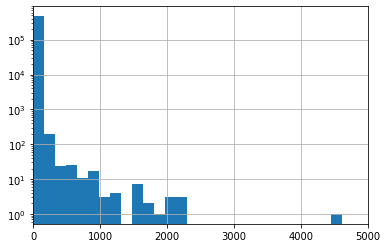

In [18]:
#gdf = df.groupby(['BasketID']).sum()

# Sales distribution.

ax = df.Sale.hist(log=True, bins=100)
ax.set_xlim((0, 5000))

In [19]:
df.describe()

,BasketID,Sale,CustomerID,Qta
count,470102.000000,470102.000000,406331.000000,470102.000000
mean,560234.152941,3.711130,15287.780447,11.991744
std,13287.747158,51.480593,1713.396198,230.587974
min,536365.000000,0.001000,12346.000000,1.000000
25%,548497.000000,1.250000,13954.000000,2.000000
50%,561084.000000,2.080000,15152.000000,4.000000
75%,571920.000000,3.750000,16791.000000,12.000000
max,581587.000000,16453.710000,18287.000000,80995.000000
